In [1]:
import sys
sys.path.append("../dataset/")
from dataset import UltraSoundImages

import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import matplotlib.colors as mcolors

In [2]:
from keras_unet_collection import losses

def custom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
        return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'custom_focal_tversky': custom_focal_tversky}

In [3]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [4]:
dataset_type = 'samsung'

def get_images(dataset_type):
    if dataset_type=='samsung':
        dataset_path = "../dataUSGthyroid/samsung_processed"
        divider = 15555.0
    elif dataset_type=='ge':
        dataset_path = "../dataUSGthyroid/GE_processed"
        divider = 255.0

    raw_images = dataset_path + "/images"
    raw_masks = dataset_path + "/masks"

    images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
    masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

    batch_size = 16
    size = (320, 320)

    images, masks = [], []
    for i in range(len(images_paths)):
        image, header = nrrd.read(images_paths[i])
        mask, header = nrrd.read(masks_paths[i])

        if size:
            image = tf.image.resize_with_pad(image, size[0], size[1])
            mask = tf.image.resize_with_pad(mask, size[0], size[1])

        if dataset_type=='ge':
            image = np.expand_dims(image[:,:,0], 2)
            mask = np.expand_dims(mask[:,:,0] , 2)

        images.append(image)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks) / divider
    return images, masks, images_paths

In [5]:
original_map = mcolors.LinearSegmentedColormap.from_list('original_mask', [(0, (0,0,0,0)), (1, 'yellow')])
pred_map = mcolors.LinearSegmentedColormap.from_list('pred_mask', [(0, (0,0,0,0)), (1, 'red')])

# Samsung

In [5]:
images, masks, paths = get_images('samsung')

In [6]:
model_path = 'output/u2net_2d/samsung/test/model/model'

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    predictions = model.predict(images) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [7]:
samsung_data = []
for image, mask, prediction, path in zip(images, masks, predictions, paths):
    dice_coef_value = dice_coef(mask, prediction)
    samsung_data.append({'path': path, 'dice_value': dice_coef_value, 'image':image, 'mask':mask, 'pred':prediction})
samsung_list = sorted(samsung_data, key=lambda x: x['dice_value'])

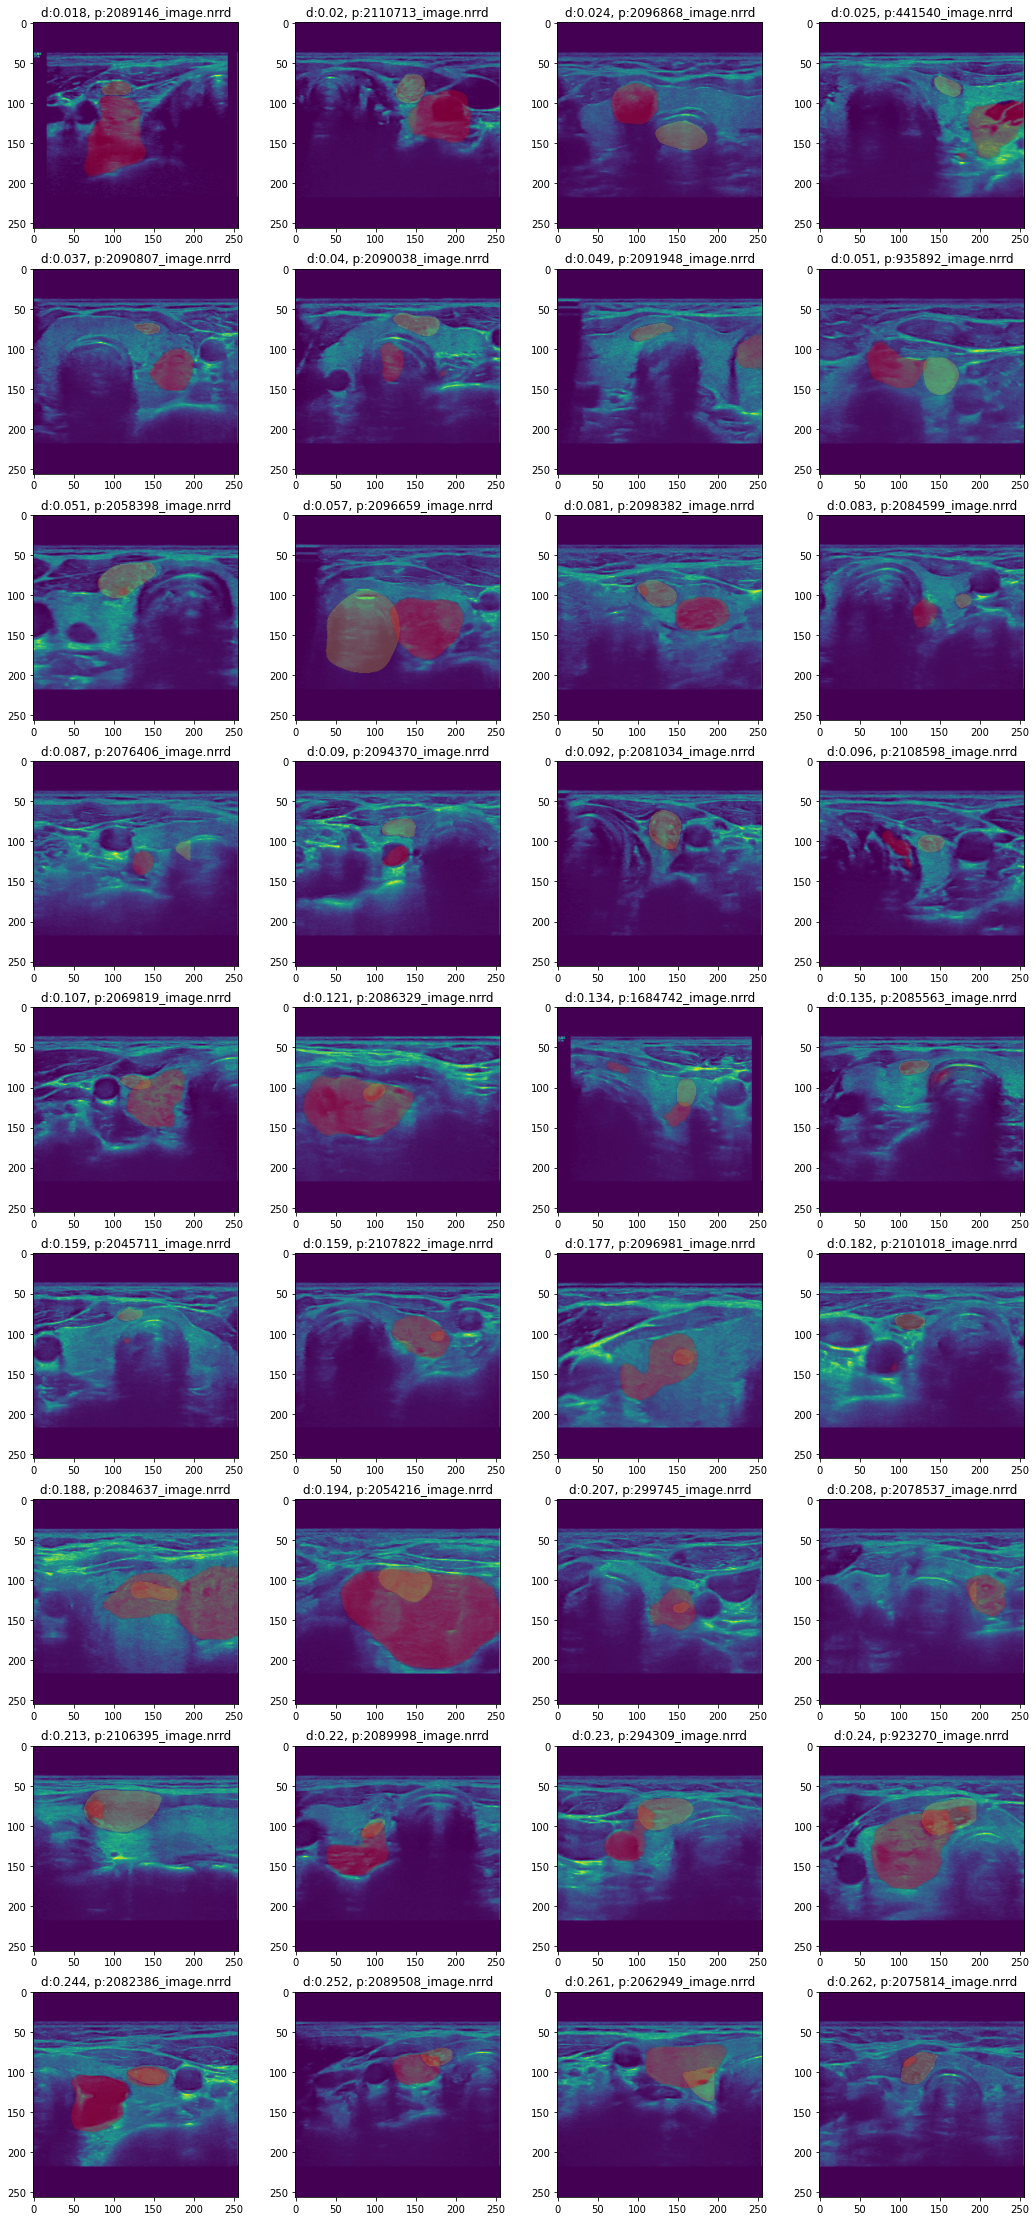

In [9]:
plt.figure(figsize=(18, 40))
for i in range(36):
    plt.subplot(9, 4, i+1)
    plt.imshow(samsung_list[i]['image']*2)
    plt.imshow(samsung_list[i]['mask'], alpha=0.2, cmap=original_map)
    plt.imshow(samsung_list[i]['pred'], alpha=0.3, cmap=pred_map)
    p = samsung_list[i]['path'].split('/')[-1]
    v = round(float(samsung_list[i]['dice_value']), 3)
    plt.title(f'd:{v}, p:{p}')

In [24]:
samsung_blacklist = [el['path'].split('/')[-1].split('_')[0] for el in samsung_list[:50]]

In [25]:
samsung_blacklist[:10]

['2089146',
 '2110713',
 '2096868',
 '441540',
 '2090807',
 '2090038',
 '2091948',
 '935892',
 '2058398',
 '2096659']

# GE

In [6]:
images, masks, paths = get_images('ge')

In [7]:
model_path = 'output/u2net_2d/ge/320_nf4_fi1/model/model'

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    predictions = model.predict(images) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [8]:
ge_data = []
for image, mask, prediction, path in zip(images, masks, predictions, paths):
    dice_coef_value = dice_coef(mask, prediction)
    ge_data.append({'path': path, 'dice_value': dice_coef_value, 'image':image, 'mask':mask, 'pred':prediction})
ge_list = sorted(ge_data, key=lambda x: x['dice_value'])

In [14]:
# ge_list = ge_list[::-1]

In [3]:
plt.figure(figsize=(18, 720))
# for i in range(324):
i = 1
j = 0
while i <= 324:
    
    plt.subplot(162, 4, i)
    plt.imshow(ge_list[j]['image']*2)
    
    plt.subplot(162, 4, i+4)
    plt.imshow(ge_list[j]['image']*2)
    plt.imshow(ge_list[j]['mask'], alpha=0.2, cmap=original_map)
    # plt.imshow(ge_list[i]['pred'], alpha=0.3, cmap=pred_map)
    p = ge_list[j]['path'].split('/')[-1]
    v = round(float(ge_list[j]['dice_value']), 3)
    plt.title(f'd:{v}, p:{p}')
    
    if i % 4 == 0:
        i += 5
    else:
        i += 1
    j += 1

In [ ]:
# np.unique(ge_list[0]['mask'])

In [18]:
ge_blacklist = [el['path'] for el in ge_list]

In [19]:
ge_blacklist = [el.split('/')[-1].split('_')[0] for el in ge_blacklist]

In [1]:
# ge_blacklist

In [58]:
from IPython.display import clear_output
import pandas as pd

def create_labels(seg_list, path):
    seg_list_len = len(seg_list)
    labeled = 0
    labels, paths, ids = [], [], []
    
    try:
        already_loaded = pd.read_csv('ge_blacklist.csv')['Path'].values
    except:
        already_loaded = []
    
    for el in seg_list:
        print('List length:', seg_list_len)
        print(f'Labeled: {labeled}')
        
        name = el['path'].split('/')[-1]
        if name in already_loaded:
            labeled += 1
            clear_output(wait=True)
            continue
        
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 2, 1)
        plt.imshow(el['image'])
        
        plt.subplot(1, 2, 2)
        plt.imshow(el['image'])
        plt.imshow(el['mask'], alpha=0.2, cmap=original_map)
        
        plt.title(name)
        plt.show()
        
        inp = int(input())
        if inp == 2:
            break
        
        paths.append(name)
        ids.append(name.split('_')[0])
        labels.append(inp)
        clear_output(wait=True)
        labeled += 1
        
        if labeled % 50 == 0:
            data = {'Path':paths, 'Id':ids, 'Blacklist':labels}
            df = pd.DataFrame(data)
            df.to_csv(path, mode='a')
            labels, paths, ids = [], [], []
            
    data = {'Path':paths, 'Id':ids, 'Blacklist':labels}
    df = pd.DataFrame(data)
    df.to_csv(path, mode='a') 
    
    print('\nlabels.csv saved!')
    return (df)

In [59]:
ge_blacklist = create_labels(ge_list, 'ge_blacklist.csv')


labels.csv saved!


In [22]:
ge_blacklist

Path  Blacklist
0  2061093_image.nrrd          0
1  2026988_image.nrrd          0
2  2052396_image.nrrd          0
3   258419_image.nrrd          0
4    96874_image.nrrd          0

In [65]:
!pip3 install xlrd

     |████████████████████████████████| 96 kB 1.2 MB/s            


In [70]:
df_loaded = pd.read_csv('ge_blacklist.csv', sep=';')

In [71]:
df_loaded.head()

Path       Id  Blacklist
0  2052396_image.nrrd  2052396          0
1   258419_image.nrrd   258419          0
2    96874_image.nrrd    96874          0
3  2051655_image.nrrd  2051655          1
4  1869459_image.nrrd  1869459          0

In [76]:
df_loaded[df_loaded['Blacklist']==0]['Id'].values

TypeError: 'numpy.ndarray' object is not callable

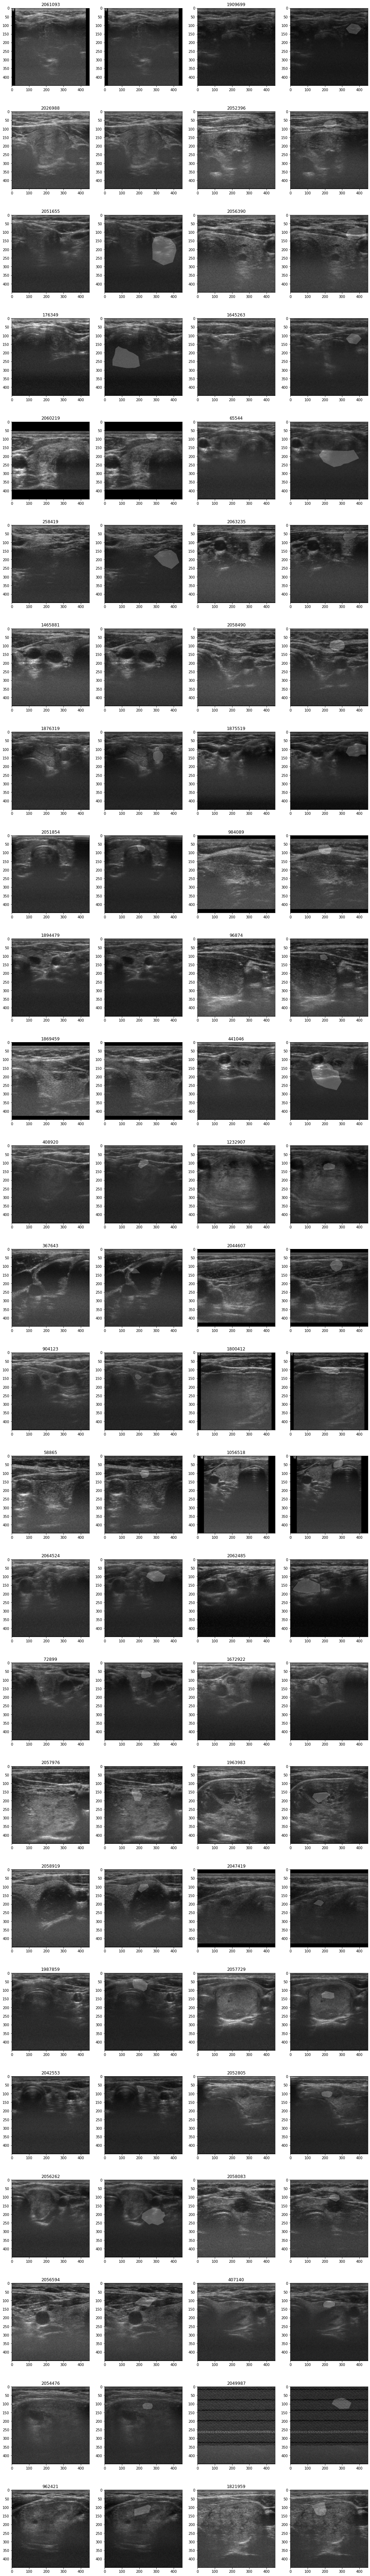

In [85]:
plt.figure(figsize=(18, 160))
j=1
for i in ge_blacklist:
    image_path = f'../dataUSGthyroid/GE_processed/images/{i}_image.nrrd'
    mask_path = f'../dataUSGthyroid/GE_processed/masks/{i}_label.nrrd'
    
    image, header = nrrd.read(image_path)
    mask, header = nrrd.read(mask_path)
    
    plt.subplot(30, 4, j)
    plt.imshow(image)
    plt.title(i)
    
    plt.subplot(30, 4, j+1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.2)
    j += 2

In [50]:
image, header = nrrd.read('../dataUSGthyroid/GE_processed/images/1909699_image.nrrd')

In [55]:
mask, header = nrrd.read('../dataUSGthyroid/GE_processed/masks/1909699_label.nrrd')

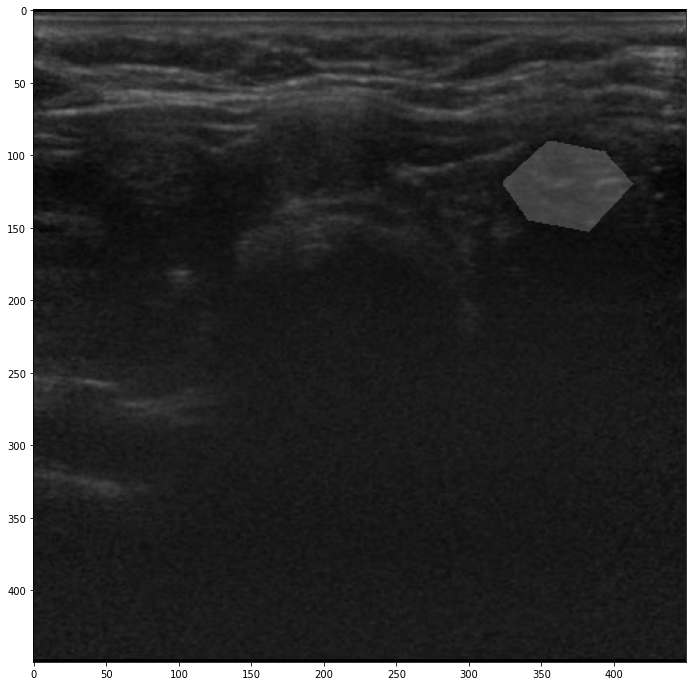

In [56]:
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.imshow(mask, alpha=0.2)
plt.show()

In [11]:
ge_blacklist

['../dataUSGthyroid/GE_processed/images/2061093_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1909699_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2026988_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2052396_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2051655_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2056390_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/176349_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1645263_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2060219_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/65544_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/258419_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2063235_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1465881_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2058490_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1876319_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1875519_image.nrrd',
 '../dataUSGthyroid/GE_proce

In [ ]:
ge_blacklist = [el['path'].split('/')[-1].split('_')[0] for el in ge_list[:50]]

In [30]:
ge_blacklist[:10]

['2061093',
 '1909699',
 '2026988',
 '2052396',
 '2051655',
 '2056390',
 '176349',
 '1645263',
 '2060219',
 '65544']

In [62]:
dataset_path = "../dataUSGthyroid/GE_processed"
divider = 255.0

raw_images = dataset_path + "/images"
raw_masks = dataset_path + "/masks"

images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

images, masks = [], []
for i in range(len(images_paths)):
    image, header = nrrd.read(images_paths[i])
    mask, header = nrrd.read(masks_paths[i])
    
    if np.sum(mask) <= 100:
        print(masks_paths[i])
    
    masks.append(mask)

../dataUSGthyroid/GE_processed/masks/1894479_label.nrrd
../dataUSGthyroid/GE_processed/masks/2026988_label.nrrd
../dataUSGthyroid/GE_processed/masks/2061093_label.nrrd
